# .Machine Learning Models - Notebook

# All in One Place: High Value Customer Identification

**All in one place** is an online retail store that sells second-hand products from various brands at lower prices. With just over a year of operation, the marketing team noticed that some customers from their base purchase more expensive products more frequently, contributing significantly to the company's revenue.

Based on this insight, the **marketing team** decided to **launch a loyalty program** for the **top customers** in their base, named Insiders.
Moreover, the Marketing teams lacks the necessary knowledge to identify the customers to join the program. As a result, this task have been assigned to the company's data team, whose should develop a solution and a report to respond the marketing queries below.
Who are the eligible individuals to participate in the program?
How many customers will be part of the group?
What are the main characteristics of these customers?
What percentage of the revenue comes from the selected group?

The company's data team, in accordance with the company's marketing team had combined that, as a first solution, they will use a RFM Matrix to identify the customers.

# 0 - IMPORTS </font>

In [1]:
import re
import warnings

import pandas                as pd
import numpy                 as np
import seaborn               as sns
from matplotlib              import pyplot          as plt
import matplotlib.cm         as cm


# ML Algorithms
import umap.umap_            as umap

from sklearn.manifold        import TSNE
from sklearn                 import mixture as mx
from sklearn                 import preprocessing as pp
from sklearn                 import ensemble      as en
from sklearn                 import decomposition as dd
from sklearn                 import cluster       as cc
from sklearn                 import metrics       as mt
from sklearn                 import ensemble      as en
from yellowbrick.cluster     import KElbowVisualizer, SilhouetteVisualizer
from scipy.cluster           import hierarchy as hc

warnings.filterwarnings( 'ignore' )

## 0.1 - Helper Functions

In [2]:
def drop_and_rename_duplicate_columns(df):
    """
    Remove duplicate columns resulting from a merge and renames columns to remove the '_x' suffix.
    Removes rows related to canceled or returned invoices: where the value of the `invoice_status_y` column is equal to 'True'.

    Parameters:
    - df (pd.DataFrame): DataFrame resulting from a merge with possible duplicate columns.

    Returns:
    - pd.DataFrame: DataFrame with duplicate columns removed and renamed.
    """

    # Checks if the 'invoice_status_y' column exists and filters where the value is True
    if 'invoice_cancelled_y' in df.columns:
        df = df[~df['invoice_cancelled_y'].fillna(False)]
    
    # Identifies columns with '_x' and '_y' suffixes after the merge
    duplicate_columns = [col for col in df.columns if col.endswith('_x') or col.endswith('_y')]
    
    # Creates a mapping to keep only one occurrence and rename columns
    cols_to_keep = {}
    for col in duplicate_columns:
        base_name = col[:-2]  # Removes the '_x' or '_y' suffix
        if base_name not in cols_to_keep:
            # Saves the column with the '_x' suffix to keep and rename
            cols_to_keep[base_name] = col

    # Defines the columns to drop, keeping only one of each duplicate pair
    cols_to_drop = set(duplicate_columns) - set(cols_to_keep.values())
    df = df.drop(columns=cols_to_drop)

    # Renames the remaining columns, removing the '_x' suffix
    df = df.rename(columns={old_name: base_name for base_name, old_name in cols_to_keep.items()})

    # Filters the columns, removing invoice_cancelled
    cols = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date','unit_price', 'customer_id', 'country']

    return df[cols]


def data_treat(df):
    """
    This function processes and transforms a given DataFrame to clean the data, engineer features, and prepare it for analysis. It performs the following tasks:
    
    1. **Column Renaming and Data Cleaning:**
       - Renames columns for consistency.
       - Removes rows with missing customer IDs.
       - Converts columns to appropriate data types.
       - Removes duplicate entries and filters noisy or irrelevant data.
    
    2. **Invoice and Return Handling:**
       - Identifies and separates canceled or returned invoices.
       - Merges purchase and return data, removing duplicate columns.
    
    3. **Data Cleaning and Filtering:**
       - Excludes products with unit prices of zero.
       - Removes stock codes related to non-product entries.
       - Drops unnecessary columns such as product descriptions.
    
    4. **Feature Engineering:**
       - Computes monetary value (`gross_revenue`) for each transaction.
       - Aggregates customer data to calculate key metrics such as:
         - Total gross revenue per customer.
         - Recency of customer purchases.
         - Number of invoices, products purchased, and distinct products bought.
         - Average ticket size (spending per transaction).
         - Purchase frequency.
    
    5. **Additional Insights:**
       - Calculates quantities of products returned by each customer.
       - Determines the most frequent purchase day of the week and month for each customer.
    
    6. **Data Preparation for Analysis:**
       - Aggregates the processed data into a new DataFrame (`df_ref`), summarizing customer behavior and transaction details.
    
    The function returns the refined and aggregated DataFrame (`df_ref`), which can be used for further analysis or modeling.
    """

    # Rename Columns:
    cols_new = ['invoice_no','stock_code','description','quantity','invoice_date','unit_price','customer_id','country']
    df.columns = cols_new

    # Removing registers with NaN values
    df= df.loc[~df['customer_id'].isna(),:]

    # Changing data types
    df[ 'invoice_date'] = pd.to_datetime( df['invoice_date'], format='%d-%b-%y') # changing the data on the column invoice data to match the correct data type
    
    df['customer_id'] = df['customer_id'].astype( int ) # changing the data on the column customer id data to match the correct data type
    
    df['country'] = df['country'].astype( str ) # Changing data type from object to string

    # Droping duplicated registers
    df = df.drop_duplicates(subset=None, inplace=False)
    
    # Applying filters to remove noise from the data

    #### REMOVING REGISTERS WHERE THE PURCHASE HAVE BEEN RETURNED OR CANCELLED ####
    # Classifying each invoice as cancelled (True) or not (False) 
    df['invoice_cancelled'] = df['invoice_no'].str.startswith("C") & (df['quantity']<0)
    
    # Separting two datasets:
    df_returns = df[df['invoice_cancelled']] # invoices cancelled
    df_purchases = df[~df['invoice_cancelled']] # invoices not cancelled
    
    # Mergin the above two data sets
    merged_df = df_purchases.merge(df_returns, on=['stock_code','unit_price','customer_id'], how='left')
    
    # Applying function to clean the new data set by removing columns etc.
    df = drop_and_rename_duplicate_columns(merged_df)
    
    # Removing the register from customer 15098 which has an extreme value of gross_revenue
    df = df.drop(df.index[146375]).reset_index(drop=True)
    
    # --- NUMERICAL ATTRIBUTES ---
    
    # Filtering products where price is equal to 0
    df = df.loc[df['unit_price'] > 0, :]
    
    # --- CATEGORICAL ATTRIBUTES ---
    
    # Filtering stock_codes that does not reffers to items
    df = df[~df['stock_code'].isin( ['POST','C2','DOT','PADS','BANK CHARGES'] )]
    
    # Description
    df = df.drop( columns='description', axis=1)


    ##### FEATURE ENGINEERING #####
    
    # data reference
    df_ref = df.drop( ['invoice_no','stock_code','quantity','invoice_date','unit_price','country'],axis=1).drop_duplicates(ignore_index=True)
    
    # Calculus of the monetary value sold
    df.loc[:,'gross_revenue'] = df.loc[:,'quantity'] * df.loc[:,'unit_price']
    df_sold = df.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

    df_ref = pd.merge( df_ref, df_sold, on='customer_id', how='left')
    
    # Recency
    df_recency = df.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
    df_recency['recency_days'] = (df['invoice_date'].max() - df_recency['invoice_date']).dt.days
    df_recency = df_recency[['customer_id','recency_days']].copy()
    df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left')

    # Calculate the quantity of invoices issues for an unique customer
    df_freq = (df.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                    .groupby('customer_id')
                                                    .count()
                                                    .reset_index()
                                                    .rename( columns={'invoice_no':'qty_invoices'}) )
                
    df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

    # Number of products
    df_freqp = (df.loc[:,['customer_id', 'quantity']].groupby('customer_id')
                                                       .sum().reset_index()
                                                       .rename( columns={'quantity':'qty_prod_purchased'}) )

    df_ref = pd.merge(df_ref, df_freqp, on='customer_id', how='left')
   
    # Calculate the range of products per customer
    
    df_prod = ( df.loc[:,['customer_id', 'stock_code']].groupby('customer_id')
                                                    .count()
                                                    .reset_index()
                                                    .rename( columns={'stock_code':'range_of_products'}) )
            
    df_ref = pd.merge(df_ref, df_prod, on='customer_id', how='left')

    # Calculate the average spenses per customer
    df_avg_ticket = ( df.loc[:, ['customer_id','gross_revenue']].groupby('customer_id')
                                                                 .mean()
                                                                 .reset_index()
                                                                 .rename( columns={'gross_revenue':'avg_ticket'}) )

    df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
    
    # Frequency
    df_max = df[['customer_id','invoice_date']].drop_duplicates().groupby('customer_id').max().reset_index() # finding the last date of purchase per customer
    df_min = df[['customer_id','invoice_date']].drop_duplicates().groupby('customer_id').min().reset_index() # finding the last date of purchase per customer

    df_aux = ( df[['customer_id','invoice_no','invoice_date']].drop_duplicates()
                                                               .groupby('customer_id')
                                                               .agg( max_ =('invoice_date', 'max'),
                                                                     min_ =('invoice_date', 'min'),
                                                                     days_=('invoice_date', lambda x:( (x.max() - x.min() ).days)+1),
                                                                     buy_ =('invoice_no', 'count'))).reset_index()

    # Frequency
    df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1 )

    # Merge
    df_ref = pd.merge(df_ref, df_aux[['customer_id','frequency']], on='customer_id', how='left')
    
    # Quantity of products cancelled
    df_returns = df_returns[['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename( columns={'quantity':'qty_returns'})
    df_returns['qty_returns'] = df_returns['qty_returns'] * -1

    df_ref = pd.merge( df_ref, df_returns, on='customer_id', how='left')
    df_ref.loc[df_ref['qty_returns'].isna(), 'qty_returns'] = 0

    # Calculate the average qty of products purchased
    df_ref['avg_qty_products_purchased'] = df_ref['qty_prod_purchased'] / df_ref['qty_invoices']

    # Retrieving the week day for the specific date
    df['week_day']= df['invoice_date'].dt.dayofweek

    # Creating the dataframe with day_week per invoice_no
    aux_02 = df[['invoice_no','customer_id','week_day']].drop_duplicates(ignore_index=True)

    # Calculus of week day most frequent
    aux_03 = aux_02[['customer_id', 'week_day']].groupby('customer_id').apply(lambda x: x.mode().iloc[0]).reset_index(drop=True)

    # Adding the new feature into the data set
    df_ref = pd.merge( df_ref, aux_03, on='customer_id', how='left')

    # Retrieving the week day for the specific date
    df['month']= df['invoice_date'].dt.month

    # Creating the dataframe with day_week per invoice_no
    aux_312 = df[['invoice_no','customer_id','month']].drop_duplicates(ignore_index=True)

    # Calculus of week day most frequent
    aux_3123 = aux_312[['customer_id', 'month']].groupby('customer_id').apply(lambda x: x.mode().iloc[0]).reset_index(drop=True)

    # Adding the new feature into the data set
    df_ref = pd.merge( df_ref, aux_3123, on='customer_id', how='left')

    return(df_ref)

def data_prep(df):
    df_one = df.drop( columns=['customer_id'], axis=1 ).copy()
    
    mms = pp.MinMaxScaler()

    # Transformer
    df_one['gross_revenue']              = mms.fit_transform( df_one[['gross_revenue']])
    df_one['recency_days']               = mms.fit_transform( df_one[['recency_days']])
    df_one['qty_invoices']               = mms.fit_transform( df_one[['qty_invoices']])
    df_one['qty_prod_purchased']         = mms.fit_transform( df_one[['qty_prod_purchased']])
    df_one['range_of_products']          = mms.fit_transform( df_one[['range_of_products']])
    df_one['avg_ticket']                 = mms.fit_transform( df_one[['avg_ticket']])
    df_one['frequency']                  = mms.fit_transform( df_one[['frequency']])
    df_one['qty_returns']               = mms.fit_transform( df_one[['qty_returns']])
    df_one['avg_qty_products_purchased'] = mms.fit_transform( df_one[['avg_qty_products_purchased']])
    df_one['week_day']                  = mms.fit_transform( df_one[['week_day']])
    df_one['month']                     = mms.fit_transform( df_one[['month']])

    return(df_one)


# 1 - DATA

## 1.1 - LOADING DATA

In [3]:
df = pd.read_csv("../data/raw/Ecommerce.csv")

# drop extra column
df = df.drop( columns=['Unnamed: 8'], axis=1)

## 1.2 - DATA TREATMENT

In [4]:
df1 = data_treat(df)

In [5]:
X = df1.copy()

## 1.3 - DATA PREPARATION

In [6]:
df2 = data_prep(df1)

In [7]:
X = df2.copy()

# 2 - MACHINE LEARNING ALGORITHMS

In [8]:
X.head()

,gross_revenue,recency_days,qty_invoices,qty_prod_purchased,range_of_products,avg_ticket,frequency,qty_returns,avg_qty_products_purchased,week_day,month
0,0.014575,0.997319,0.163366,0.006085,0.031863,0.004764,1.000000,0.000457,0.004350,0.333333,0.909091
1,0.008615,0.083110,0.044554,0.005922,0.020248,0.004394,0.001395,0.000444,0.014687,0.166667,0.909091
2,0.023446,0.005362,0.069307,0.024818,0.035159,0.007118,0.002052,0.000630,0.041237,0.166667,0.909091
3,0.003408,0.254692,0.019802,0.002240,0.004238,0.008399,0.000734,0.000000,0.011095,0.333333,0.272727
4,0.015835,0.067024,0.069307,0.009962,0.014911,0.011489,0.002208,0.000358,0.016481,1.000000,0.181818


## 2.1 - STUDY OF THE DATA SPACE

The original data space, referred to as the feature space, consists of features in their raw, unprocessed form as provided in the dataset. While this space contains all the original information, it may not always be optimal for clustering tasks. For example, the data might suffer from high dimensionality, noise, or non-linear relationships between features, making it difficult to discern meaningful groups.

To address this, we can transform the data into a embedding space, a lower-dimensional representation derived from the original features. In this new space, the data is reorganized to emphasize patterns, distances, or relationships that are more conducive to clustering. The goal is to structure the data such that similar points are closer together, and dissimilar points are farther apart.

Transforming data from the feature space to the embedding space relies on principles from linear algebra and machine learning. Common methods include:

Linear Transformations (via Linear Algebra):

Techniques like matrix factorization or eigenvalue decomposition that combine features linearly (e.g., scaling, rotation, or projection).

Example: Principal Component Analysis (PCA), which reduces dimensionality while preserving variance.

Machine Learning Algorithms:

Dimensionality Reduction: Non-linear methods like t-SNE or UMAP project data into a lower-dimensional space while preserving local or global structure (useful for visualization).

Tree-Based Embeddings: Decision trees or random forests can generate embeddings by using leaf node indices as new features. Each leaf represents a hyperrectangle in the feature space, encoding non-linear decision boundaries.

Deep Learning: Autoencoders or neural networks can learn embeddings by compressing data into latent representations.

### 2.1.1 - PCA

# **Principal Component Analysis (PCA)**

## **Definition & Purpose**  
Principal Component Analysis (PCA) is a statistical technique used for **dimensionality reduction**, transforming high-dimensional data into a lower-dimensional space while preserving as much variance as possible. By identifying patterns in data, PCA simplifies complexity without significant information loss, addressing challenges like the *curse of dimensionality*, computational inefficiency, and difficulties in visualizing high-dimensional datasets.

---

## **How PCA Works**  
PCA achieves dimensionality reduction through the following steps:  

### **1. Standardization**  
- Center the data by subtracting the mean of each feature.  
- Scale features to unit variance if variables differ in measurement units.  

### **2. Covariance Matrix or SVD**  
- **Covariance Matrix Approach**: Compute the covariance matrix to measure feature relationships. Its eigenvectors (principal components) indicate directions of maximum variance, with eigenvalues quantifying the variance magnitude.  
- **Singular Value Decomposition (SVD)**: Directly decompose the standardized data matrix **X** into:

  $$ X = U \Sigma V^T $$

  where columns of **V** are the principal components. This method avoids explicit covariance matrix calculation, enhancing numerical stability.  

### **3. Sorting & Selection**  
- Sort eigenvectors by descending eigenvalues.  
- Select top **k** components to retain a desired proportion of variance (e.g., 95%).  

### **4. Projection**  
- Transform data into the new subspace via:

  $$ X_{\text{new}} = X W $$

  where **W** contains the selected eigenvectors.  

---

## **Key Concepts**  
- **Variance Explained**: Each principal component contributes a percentage of total variance, calculable as:

  $$ \frac{\lambda_i}{\sum \lambda_i} $$

  (eigenvalue ratios). Tools like **scree plots** or cumulative variance thresholds guide component selection.  
- **Loadings & Scores**: Loadings are coefficients in eigenvectors, showing original features' contributions to components. Scores are projected data points in the new space.  
- **Orthogonality**: Components are orthogonal, ensuring uncorrelated dimensions.  

---

## **Applications**  
PCA is widely used across domains:  
- **Bioinformatics**: Reducing gene expression dimensions for clustering.  
- **Finance**: Simplifying portfolio risk factors.  
- **Image Processing**: Eigenfaces for facial recognition.


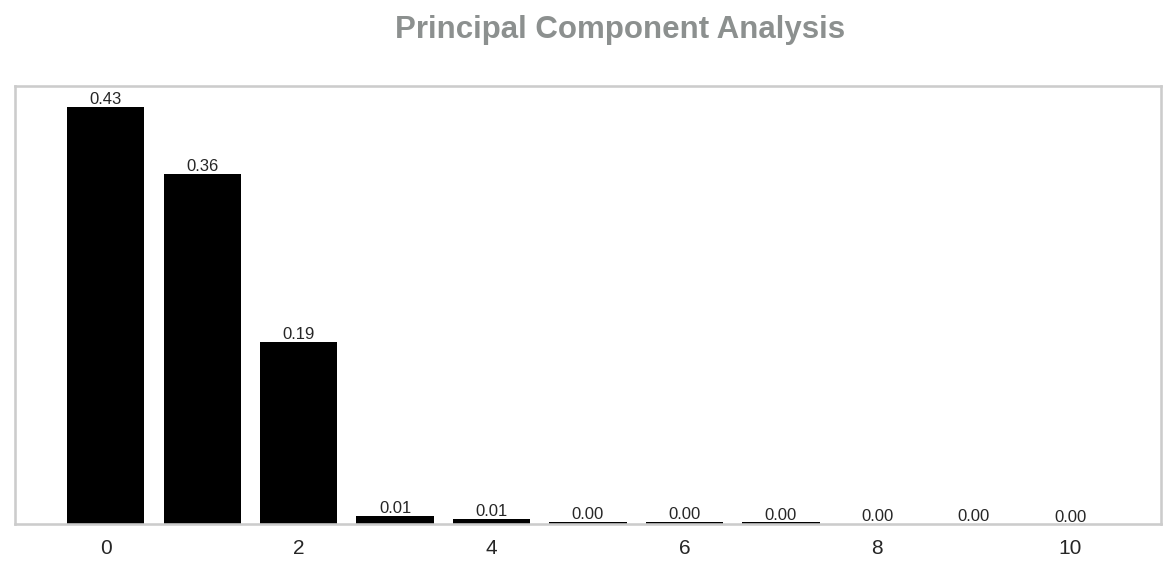

In [9]:
##### CHART CREATION #####
fig, ax = plt.subplots(figsize = (8, 4), dpi=150)
pca = dd.PCA ( n_components = X.shape[1] )

principal_components = pca.fit_transform( X )
features = range( pca.n_components_ )

bars = plt.bar( features, pca.explained_variance_ratio_, color='black' )

##### DESIGN #####

##### HIDE ELEMENTS OF CHART #####


plt.gca().axes.get_yaxis().set_visible(False) # Hide y axis
# plt.gca().axes.get_xaxis().set_visible(False) # Hide x axis
# ax.set_axis_off() # hide both axis
ax.grid(False) # hiding the grid

##### ADD & EDITING TEXT ELEMENTS #####

# Title
plt.text(x=3,
         y=0.5,
         s='Principal Component Analysis',
         fontsize=15,
         color='#8C908F',
         weight='bold' );

# Add labels on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

fig.tight_layout()
plt.show()


# Data frame with the PCA data
df_pca = pd.DataFrame( principal_components )

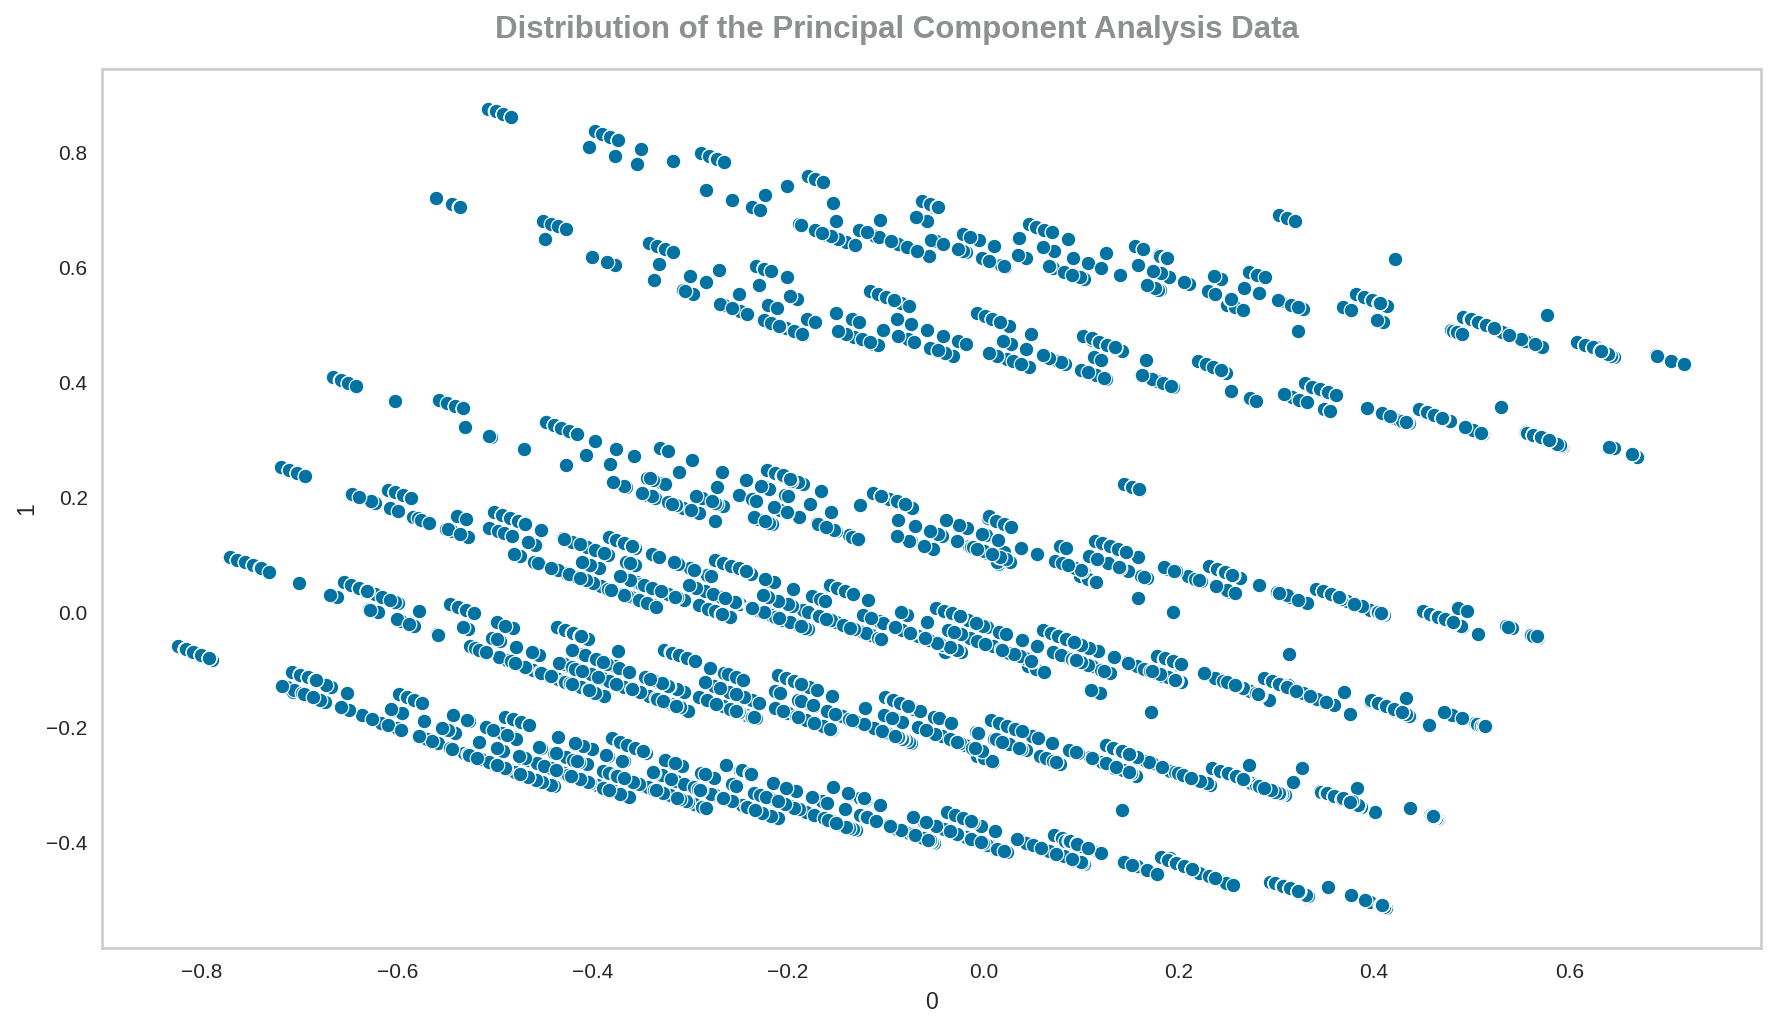

In [10]:
##### CHART CREATION #####
fig, ax = plt.subplots(figsize = (12, 7), dpi=150)
sns.scatterplot( x=0, y=1, data=df_pca)

##### DESIGN #####

##### HIDE ELEMENTS OF CHART #####


#plt.gca().axes.get_yaxis().set_visible(False) # Hide y axis
#plt.gca().axes.get_xaxis().set_visible(False) # Hide x axis
#ax.set_axis_off() # hide both axis
ax.grid(False) # hiding the grid

##### ADD & EDITING TEXT ELEMENTS #####

#Title
plt.text(x=-0.5,
         y=1,
         s='Distribution of the Principal Component Analysis Data',
         fontsize=15,
         color='#8C908F',
         weight='bold' );

fig.tight_layout()
plt.show()

### 2.1.2 - UMAP

# **Uniform Manifold Approximation and Projection (UMAP)**

## **Definition & Purpose**  
UMAP is a nonlinear dimensionality reduction technique designed to preserve **both local and global structures** in high-dimensional data. Unlike PCA, which focuses on linear variance, UMAP leverages manifold learning to model complex, nonlinear relationships. Its primary goals are to:  
- Simplify visualization of high-dimensional data (e.g., in 2D/3D).  
- Maintain meaningful topological structures (clusters, connections).  
- Improve efficiency in downstream tasks like clustering or classification.  

---

## **How UMAP Works**  
UMAP operates in three key stages:  

### **1. Graph Construction in High-Dimensional Space**  
- **Nearest Neighbors**: For each data point, identify **k** nearest neighbors (controlled by `n_neighbors`).  
- **Fuzzy Topology**: Build a weighted graph where edges represent probabilistic "connectedness" between points. Weights are computed using a kernel that decays with distance, ensuring nearby points are strongly connected.  

### **2. Optimization of Low-Dimensional Representation**  
- Initialize points randomly in the target space (e.g., 2D).  
- Define a similar fuzzy graph in the low-dimensional space.  
- Minimize the **cross-entropy** between the high- and low-dimensional graphs, preserving topological relationships.  

### **3. Stochastic Gradient Descent**  
- Use optimization to iteratively adjust the low-dimensional layout, balancing local structure (neighborhood preservation) and global structure (avoiding overcrowding).  

---

## **Key Concepts**  
- **Manifold Learning**: Assumes data lies on a lower-dimensional manifold embedded in high-dimensional space (e.g., a swiss roll in 3D).  
- **Local vs. Global Structure**:  
  - **Local**: Relationships between nearby points (controlled by `n_neighbors`).  
  - **Global**: Broader patterns and cluster separation (influenced by optimization).  
- **Hyperparameters**:  
  - `n_neighbors`: Balances local/global focus (smaller values emphasize local structure).  
  - `min_dist`: Controls spacing between points in the output (lower values create denser clusters).  

---

## **Applications**  
UMAP excels in domains requiring nonlinear pattern discovery:  
- **Bioinformatics**: Visualizing single-cell RNA sequencing data to identify cell types.  
- **Image Processing**: Reducing dimensions of image embeddings for clustering.  
- **Natural Language Processing (NLP)**: Exploring word or document embeddings.  
- **Exploratory Data Analysis**: Revealing hidden clusters or relationships in complex datasets.  

---

## **Considerations & Limitations**  
- **Nonlinearity**: Captures complex patterns PCA misses but sacrifices interpretability of components.  
- **Stochasticity**: Results vary slightly across runs due to random initialization.  
- **Parameter Sensitivity**: Performance depends on tuning `n_neighbors` and `min_dist`.  
- **Computational Cost**: More resource-intensive than PCA but faster than t-SNE for large datasets.  

---

## **Example**  
A dataset with 1,000 features (e.g., gene expressions) can be reduced to 2D using UMAP, revealing distinct cell clusters that correspond to biological subtypes. Unlike PCA, which might collapse nonlinear relationships, UMAP preserves the manifold’s "shape."  

---

## **Comparison to PCA**  
| **Aspect**          | **PCA**                          | **UMAP**                          |  
|----------------------|----------------------------------|-----------------------------------|  
| **Linearity**        | Linear                           | Nonlinear                         |  
| **Structure Preserved** | Global variance               | Local + global topology           |  
| **Interpretability** | Components are linear combos    | Black-box, visual patterns         |  
| **Use Case**         | Statistical analysis, denoising | Visualization, complex clustering |  

---

## **Conclusion**  
UMAP is a powerful complement to PCA, particularly for visualizing and analyzing nonlinear datasets. While PCA remains a go-to for linear dimensionality reduction and interpretability, UMAP’s ability to unravel intricate structures makes it indispensable in modern data science. By understanding both tools, analysts can choose the right approach based on data characteristics and project goals.  


In [11]:
# UMAP 
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# Embedding 
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

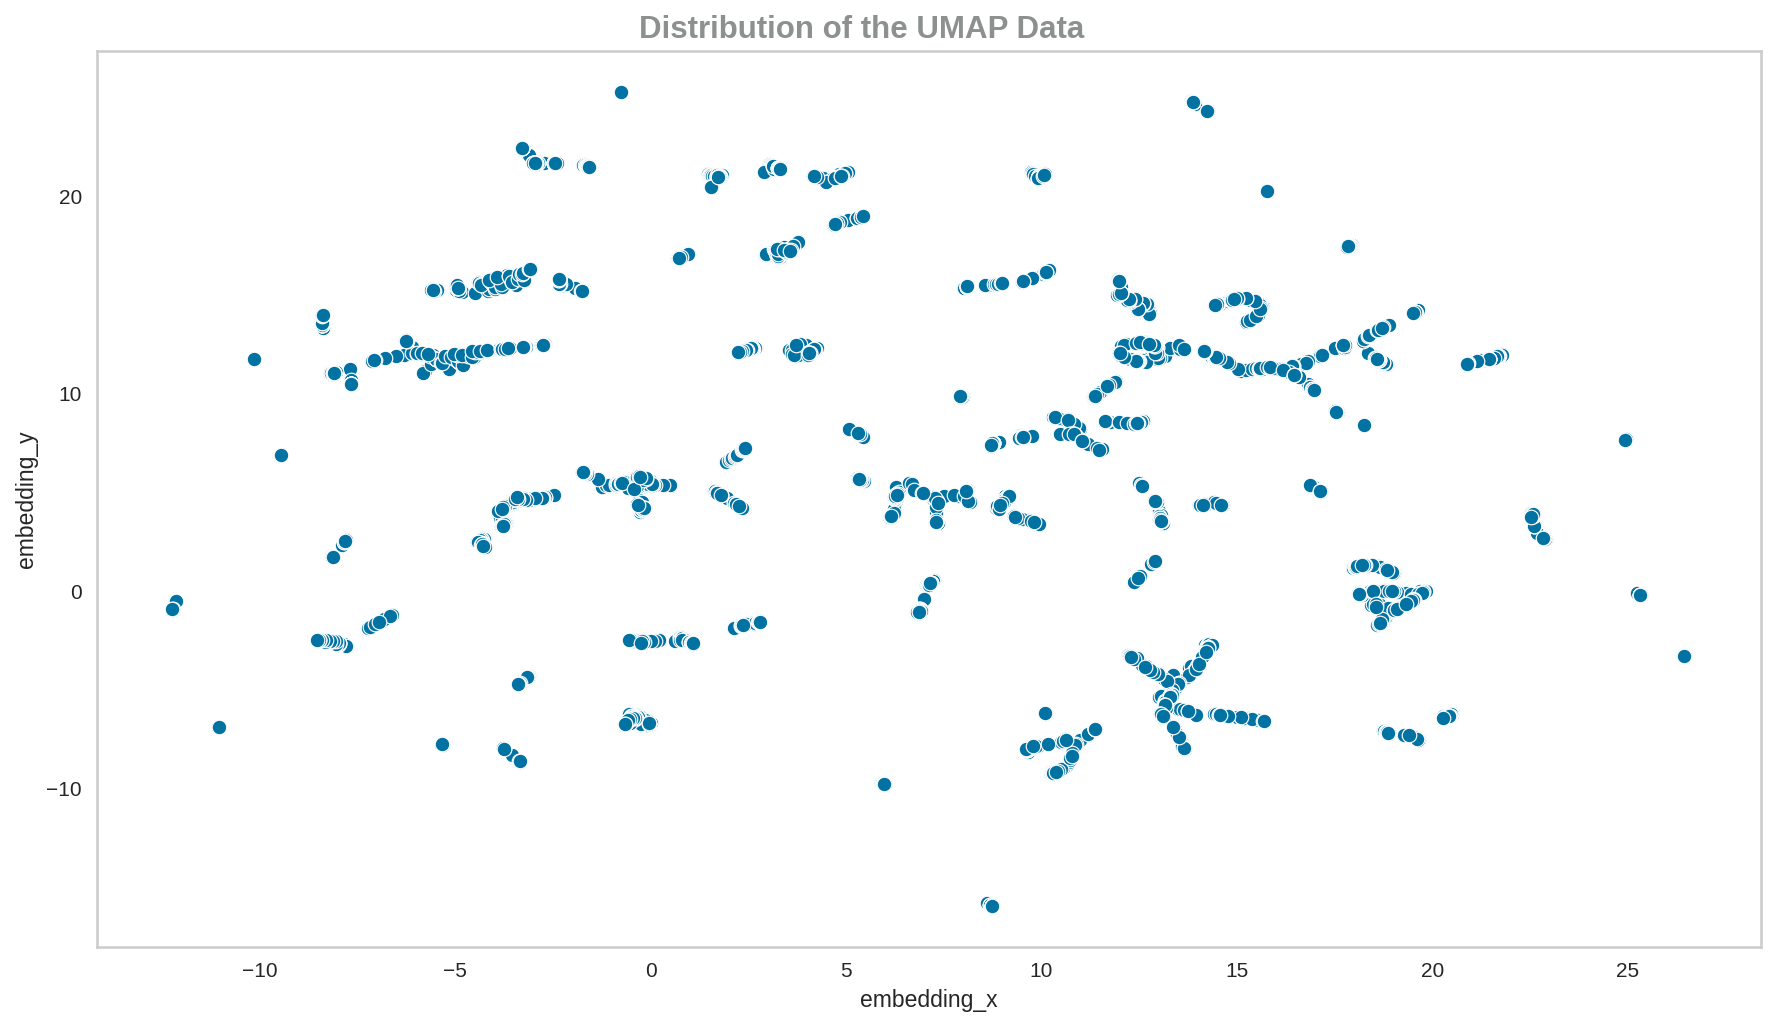

In [12]:
##### CHART CREATION #####
fig, ax = plt.subplots(figsize = (12, 7), dpi=150)
# Plot UMAP
sns.scatterplot( 
                 x='embedding_x',
                 y='embedding_y',
                 data=df_pca)

##### DESIGN #####

##### HIDE ELEMENTS OF CHART #####


#plt.gca().axes.get_yaxis().set_visible(False) # Hide y axis
# plt.gca().axes.get_xaxis().set_visible(False) # Hide x axis
# ax.set_axis_off() # hide both axis
ax.grid(False) # hiding the grid

##### ADD & EDITING TEXT ELEMENTS #####

#Title
plt.text(x=-0.3,
         y=28,
         s='Distribution of the UMAP Data',
         fontsize=15,
         color='#8C908F',
         weight='bold' );

fig.tight_layout()
plt.show()

### 2.1.3 - t-SNE

# **t-Distributed Stochastic Neighbor Embedding (t-SNE): A Nonlinear Technique for Visualizing High-Dimensional Data**  

## **Definition & Purpose**  
**t-SNE** is a nonlinear dimensionality reduction method designed primarily for **visualizing high-dimensional data** in 2D or 3D. It focuses on preserving **local structures** (relationships between nearby points) while approximating global patterns. Unlike PCA, t-SNE is probabilistic and excels at revealing clusters, making it ideal for exploratory data analysis.  

---

## **How t-SNE Works**  
t-SNE operates in two main stages:  

### **1. Modeling Similarities in High-Dimensional Space**  
- Compute pairwise similarities between points using a **Gaussian kernel**, converting distances into probabilities.  
- The probability $p_{ij}$ that point $i$ would pick point $j$ as its neighbor reflects their similarity.  

### **2. Optimizing Low-Dimensional Embedding**  
- Create a similar probability distribution $q_{ij}$ in the low-dimensional space using a **Student’s t-distribution** (heavier tails reduce crowding).  
- Minimize the **Kullback-Leibler (KL) divergence** between $p_{ij}$ and $q_{ij}$ via gradient descent, iteratively adjusting the low-dimensional layout.  

---

## **Key Concepts**  
- **KL Divergence**: Measures how well the low-dimensional probabilities $q_{ij}$ match the high-dimensional $p_{ij}$. Lower KL divergence indicates better preservation of structure.  
- **Perplexity**: Controls the effective number of neighbors considered for each point (typical range: 5–50). Balances local vs. global sensitivity.  
- **Crowding Problem**: The t-distribution in the low-dimensional space prevents points from collapsing into a central blob, addressing the "crowding" issue seen with Gaussian kernels.  
- **Non-Convex Optimization**: Multiple runs may yield different results due to random initialization and local minima.  

---

## **Applications**  
t-SNE is widely used for visualization tasks:  
- **Bioinformatics**: Cluster analysis of gene expression or protein interaction data.  
- **Computer Vision**: Visualizing embeddings of images (e.g., MNIST digits).  
- **NLP**: Exploring semantic relationships in word embeddings.  
- **Anomaly Detection**: Identifying outliers as isolated points in the embedding.  

---

## **Considerations & Limitations**  
- **Computational Cost**: Scales quadratically with dataset size ($O(n^2)$), making it slow for large datasets (>10k samples).  
- **Parameter Sensitivity**: Results depend heavily on **perplexity** and **learning rate**. Poor tuning can hide or distort patterns.  
- **Global Structure Loss**: Prioritizes local over global relationships (e.g., distances between clusters are often meaningless).  
- **Non-Replicability**: Different runs on the same data may produce varying layouts.  
- **No Transform for New Data**: t-SNE embeddings are not generalizable; new points cannot be projected into an existing embedding.  

---

## **Example**  
A dataset of 50,000 images (e.g., MNIST digits) can be reduced to 2D with t-SNE, revealing tight clusters of similar digits (e.g., all "3"s grouped together). However, distances between clusters (e.g., "3" vs. "8") are not interpretable.  

---

## **Comparison to PCA and UMAP**  
| **Aspect**          | **PCA**                          | **UMAP**                          | **t-SNE**                          |  
|----------------------|----------------------------------|-----------------------------------|------------------------------------|  
| **Linearity**        | Linear                           | Nonlinear                         | Nonlinear                          |  
| **Focus**            | Global variance                  | Local + global topology           | Local structure                    |  
| **Speed**            | Fast ($O(n^3)$)                  | Faster than t-SNE for large data  | Slow ($O(n^2)$)                    |  
| **Interpretability** | Components = linear combos       | Black-box, visual patterns         | Visual clusters only               |  
| **Generalization**   | New data can be projected        | Supports out-of-sample extension  | No projection for new data         |  
| **Stability**        | Deterministic                    | Slight stochasticity               | Highly stochastic                  |  

---

## **When to Use t-SNE?**  
- **Visualization**: Ideal for small-to-medium datasets (<10k samples) where cluster exploration is key.  
- **Local Patterns**: Prioritizes fine-grained relationships (e.g., identifying subclusters).  
- **Qualitative Insights**: Use alongside PCA/UMAP for complementary perspectives.  

---

## **Conclusion**  
t-SNE is a powerful tool for **visual storytelling** in high-dimensional data, uncovering hidden clusters that linear methods like PCA miss. While it struggles with scalability, replicability, and global structure, its ability to highlight local patterns makes it indispensable for exploratory analysis. For large datasets or tasks requiring reproducibility, UMAP is often preferred, but t-SNE remains a cornerstone of nonlinear dimensionality reduction in research and industry.  


In [14]:
# UMAP 
reducer = TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# Embedding 
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

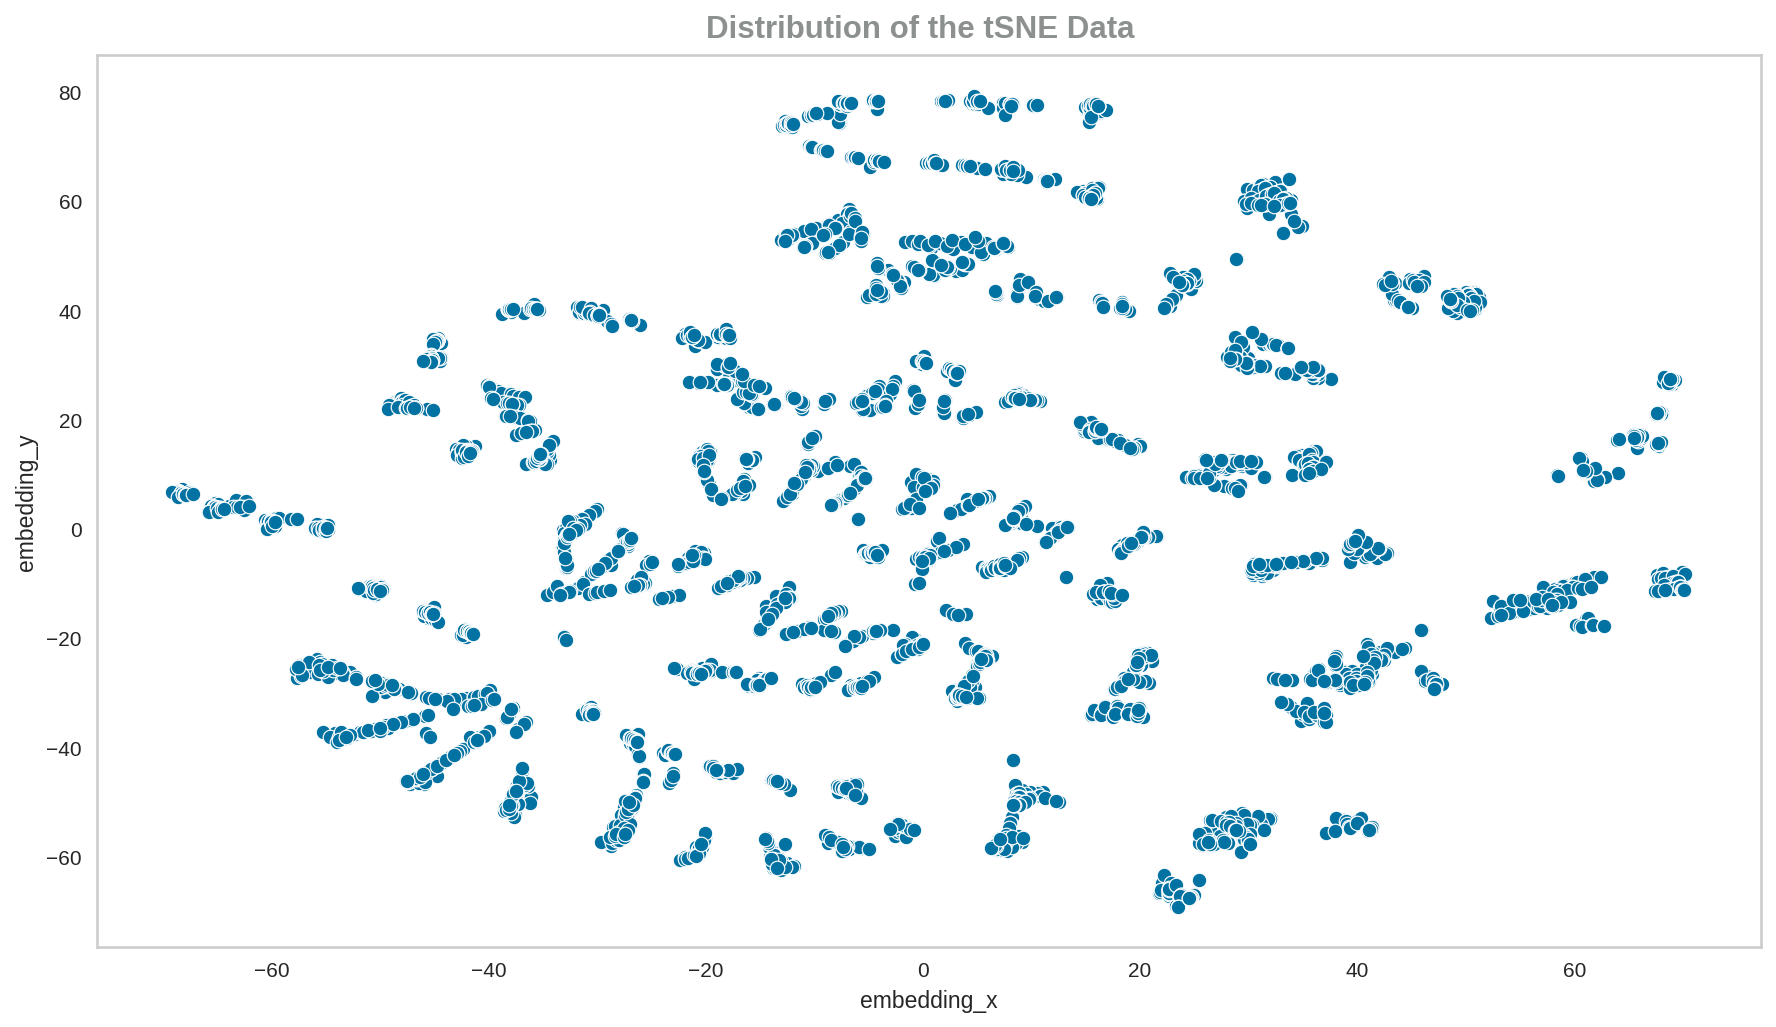

In [15]:
##### CHART CREATION #####
fig, ax = plt.subplots(figsize = (12, 7), dpi=150)
# Plot UMAP

sns.scatterplot( 
                 x='embedding_x',
                 y='embedding_y',
                 data=df_pca)


##### DESIGN #####

##### HIDE ELEMENTS OF CHART #####


#plt.gca().axes.get_yaxis().set_visible(False) # Hide y axis
# plt.gca().axes.get_xaxis().set_visible(False) # Hide x axis
# ax.set_axis_off() # hide both axis
ax.grid(False) # hiding the grid

##### ADD & EDITING TEXT ELEMENTS #####

#Title
plt.text(x=-20,
         y=90,
         s='Distribution of the tSNE Data',
         fontsize=15,
         color='#8C908F',
         weight='bold' );

fig.tight_layout()
plt.show()

### 2.1.4 - TREE EMBEDDING

**Tree-Based Embeddings: Supervised Feature Learning with Decision Trees**

**Definition & Purpose**  
Tree-based embeddings are a class of techniques that use **decision trees** (e.g., Random Forests, Gradient Boosted Trees) to transform high-dimensional data into lower-dimensional representations. Unlike PCA or UMAP, these embeddings are **supervised** (leveraging target labels) or **semi-supervised**, capturing patterns relevant to prediction tasks. They are particularly effective for:  
- Encoding complex, non-linear feature interactions.  
- Generating interpretable representations tied to decision logic.  
- Improving model performance in downstream tasks (e.g., classification, regression).  

---

### **How Tree-Based Embeddings Work**  
Tree-based embeddings are generated in two primary ways:  

1. **Leaf Node Embedding**  
   - Train a tree ensemble (e.g., Random Forest, XGBoost).  
   - For each tree, pass a data point through its splits and record the **index of the leaf node** it reaches.  
   - Represent each sample as a vector of leaf indices (e.g., one index per tree).  
   - Convert these indices into a binary or one-hot encoded format, creating a sparse high-dimensional embedding.  

2. **Proximity-Based Embedding**  
   - Train a tree ensemble.  
   - For all pairs of data points, compute their **proximity**: the fraction of trees where they land in the same leaf node.  
   - Use the proximity matrix as a similarity measure and apply dimensionality reduction (e.g., MDS, PCA) to create a low-dimensional embedding.  

3. **Supervised Embedding via Feature Importance**  
   - Extract **split criteria** (e.g., feature thresholds) from trained trees.  
   - Use these splits to engineer new features (e.g., binary flags indicating whether a sample meets a split condition).  

---

### **Key Concepts**  
- **Supervision**: Embeddings directly incorporate label information (unlike PCA/UMAP/t-SNE).  
- **Feature Interactions**: Splits in trees naturally model interactions between features (e.g., `IF age > 30 AND income < $50k`).  
- **Proximity Matrix**: A measure of similarity based on shared leaf nodes across trees.  
- **Leaf Index Encoding**: Sparse representations where each dimension corresponds to a tree’s decision path.  

---

### **Applications**  
Tree-based embeddings are used in domains requiring interpretability and non-linear feature learning:  
- **Healthcare**: Risk stratification using patient data (e.g., embedding lab results and demographics).  
- **Finance**: Fraud detection by encoding transaction patterns.  
- **Recommendation Systems**: Representing user-item interactions for collaborative filtering.  
- **Model Stacking**: Using embeddings as input to secondary models (e.g., logistic regression).  

---

### **Considerations & Limitations**  
- **Computational Cost**: Training large tree ensembles can be slow for massive datasets.  
- **Sparsity**: Leaf index embeddings are high-dimensional and sparse, requiring compression (e.g., PCA) for practical use.  
- **Model Dependency**: Embedding quality depends on the tree ensemble’s hyperparameters (e.g., tree depth, number of trees).  
- **Interpretability Trade-off**: While trees are interpretable, embeddings derived from them may lose transparency.  

---

### **Example**  
A dataset with 100 features (e.g., customer demographics, purchase history) is passed through a Random Forest. Each customer is mapped to a 500-dimensional vector (one leaf index per tree in a 500-tree forest). This embedding is reduced to 10 dimensions via PCA and used to train a classifier, improving accuracy by 15% compared to raw features.  

---

### **Comparison to PCA, UMAP, and t-SNE**  
| **Aspect**          | **Tree-Based Embedding**        | **PCA**               | **UMAP/t-SNE**        |  
|----------------------|----------------------------------|-----------------------|------------------------|  
| **Supervision**      | Supervised/Semi-Supervised       | Unsupervised          | Unsupervised           |  
| **Linearity**        | Nonlinear                        | Linear                | Nonlinear              |  
| **Interpretability** | High (tied to tree splits)       | Moderate              | Low                    |  
| **Use Case**         | Prediction tasks, feature engineering | Denoising, visualization | Visualization, clustering |  
| **Data Scaling**     | Not required                     | Required              | Required               |  

---

### **Implementation Tools**  
- **Scikit-learn**: Use `RandomForestClassifier` or `GradientBoostingClassifier` to generate leaf indices.  
- **LightGBM/XGBoost**: Efficient tree ensembles with built-in methods for extracting leaf indices.  
- **Proximity Matrices**: Custom implementations using tree structures.  

---

### **Conclusion**  
Tree-based embeddings bridge the gap between traditional feature engineering and modern representation learning. By leveraging the hierarchical decision logic of trees, they create interpretable, task-specific embeddings that excel in supervised learning scenarios. While less common for pure visualization compared to UMAP or t-SNE, they are powerful tools for enhancing predictive models and uncovering actionable insights in domains where transparency matters.  

--- 

This integrates seamlessly with your earlier sections while highlighting the unique strengths of tree-based methods. Let me know if you’d like to add code snippets or expand on specific applications!

In [ ]:
# Creation of an embedding space using randon forest

In [16]:
# Training dataset
X = df1.drop( columns=['gross_revenue'], axis=1 ).copy()
y = df1['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model trainig
rf_model.fit(X, y)

RandomForestRegressor(random_state=42)

In [17]:
df_leaf = pd.DataFrame( rf_model.apply( X ) ) # here i am selecting the datas from the leaf of tree

In [18]:
# UMAP 
reducer = umap.UMAP( random_state = 42 )
embedding = reducer.fit_transform( df_leaf )

# Embedding 
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]



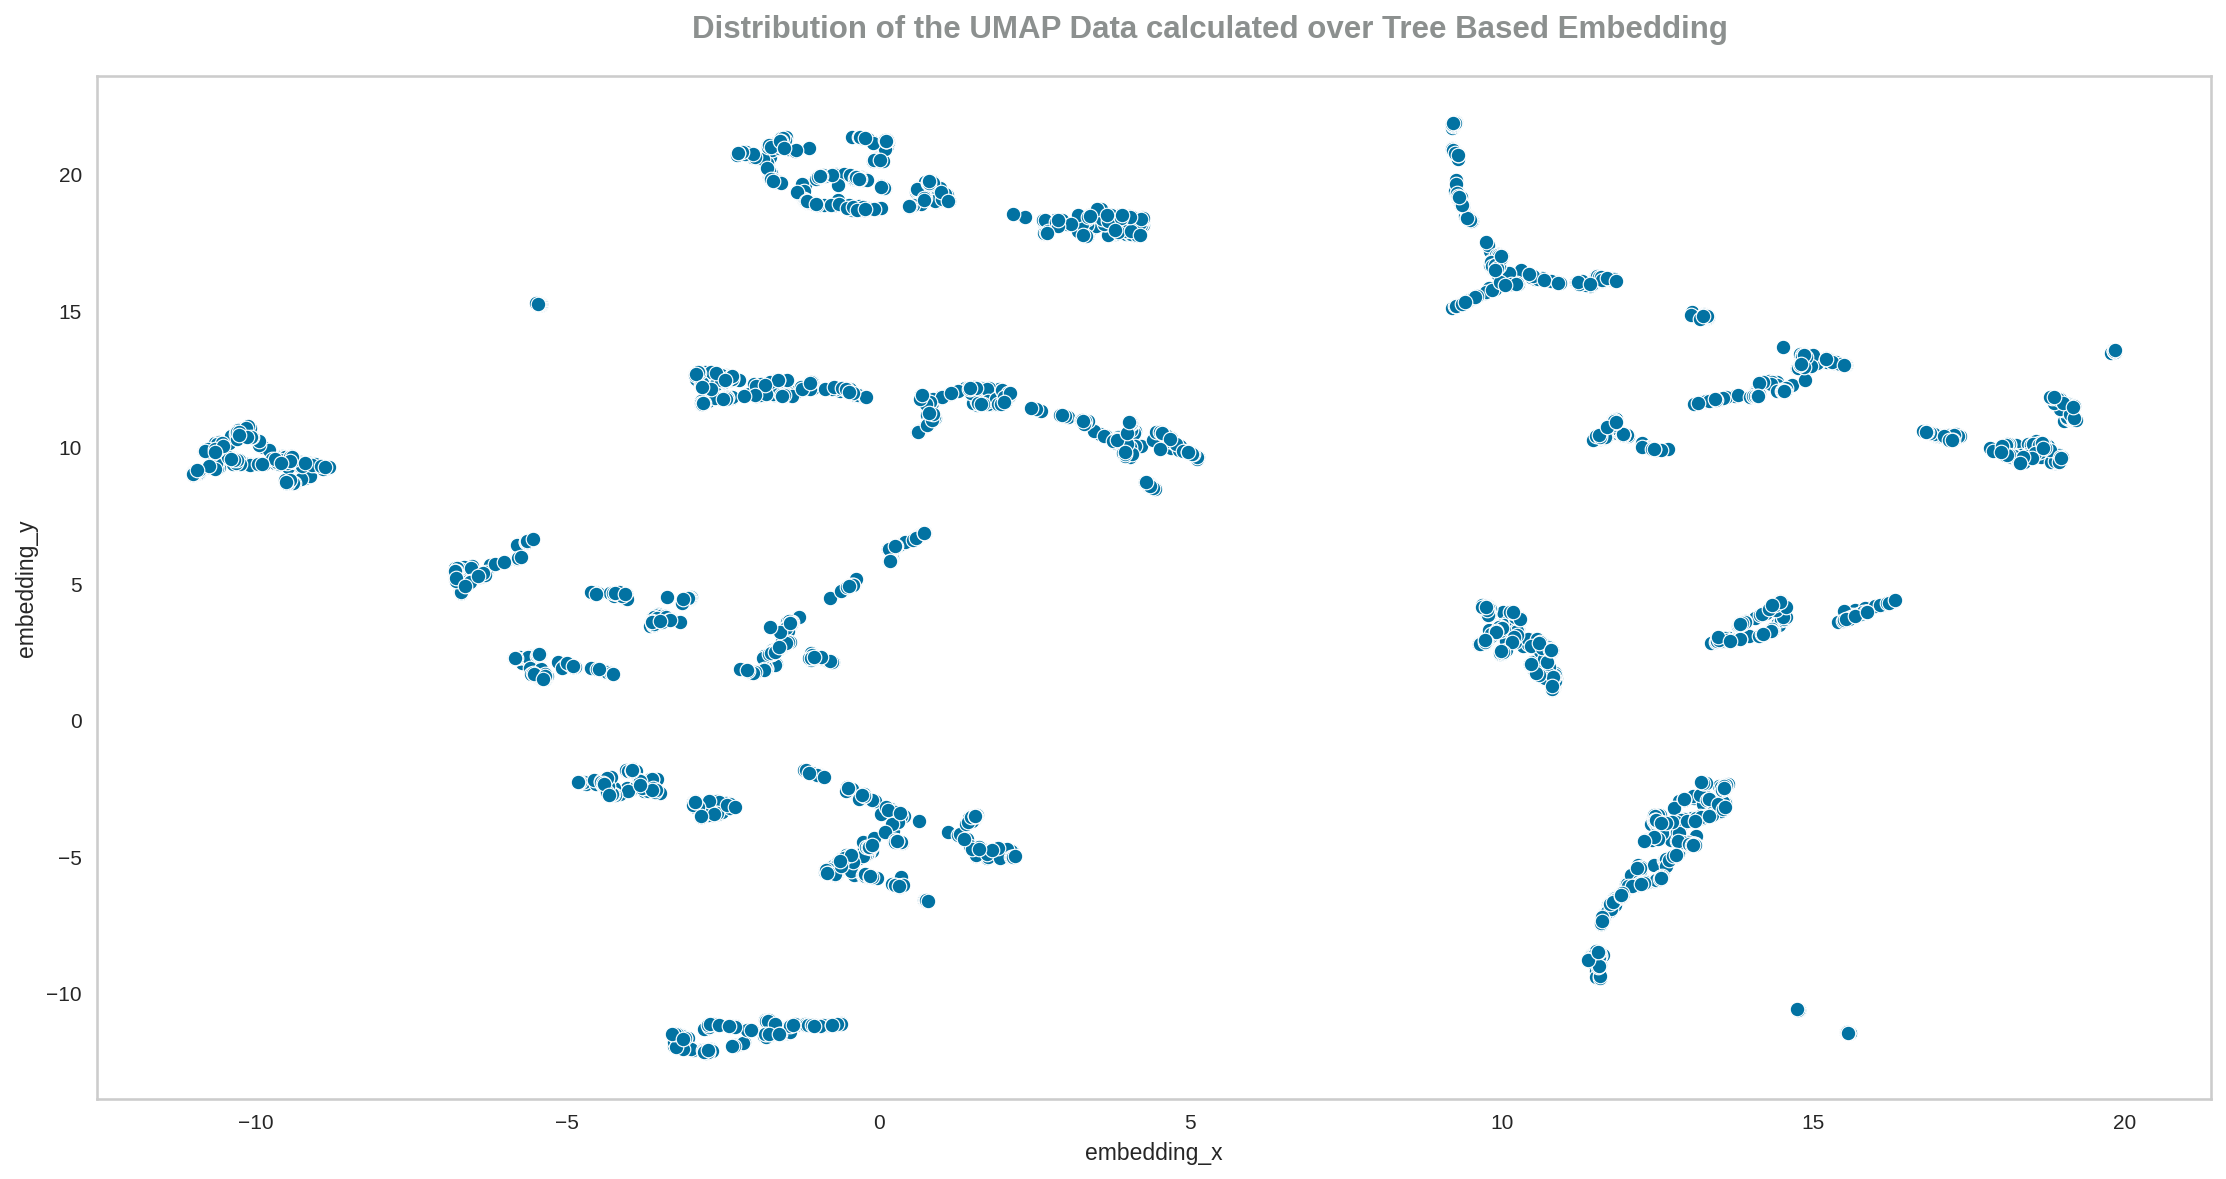

In [19]:
##### CHART CREATION #####
fig, ax = plt.subplots(figsize = (15, 8), dpi=150)

# Plot UMAP
sns.scatterplot( 
                 x='embedding_x',
                 y='embedding_y',
                 data=df_tree)


##### DESIGN #####

##### HIDE ELEMENTS OF CHART #####


#plt.gca().axes.get_yaxis().set_visible(False) # Hide y axis
# plt.gca().axes.get_xaxis().set_visible(False) # Hide x axis
# ax.set_axis_off() # hide both axis
ax.grid(False) # hiding the grid

##### ADD & EDITING TEXT ELEMENTS #####

#Title
plt.text(x=-3,
         y=25,
         s='Distribution of the UMAP Data calculated over Tree Based Embedding',
         fontsize=15,
         color='#8C908F',
         weight='bold' );

fig.tight_layout()
plt.show()

## 2.2 - Applying Machine Learning onto the embedding space to locate the best customers

In [20]:
X = df_tree.copy()

In [21]:
cluster = np.arange(2, 25, 1)

### 2.2.1 - K-Means

In [22]:
kmeans_list = []
for k in cluster:
    # Model Definition
    kmeans_model = cc.KMeans( n_clusters=k )

    # Model Training
    kmeans_model.fit( X )
    # Model Predict
    labels = kmeans_model.predict( X )

    # Model Performance
    sil = mt.silhouette_score( X, labels, metric='euclidean')
    kmeans_list.append( sil )

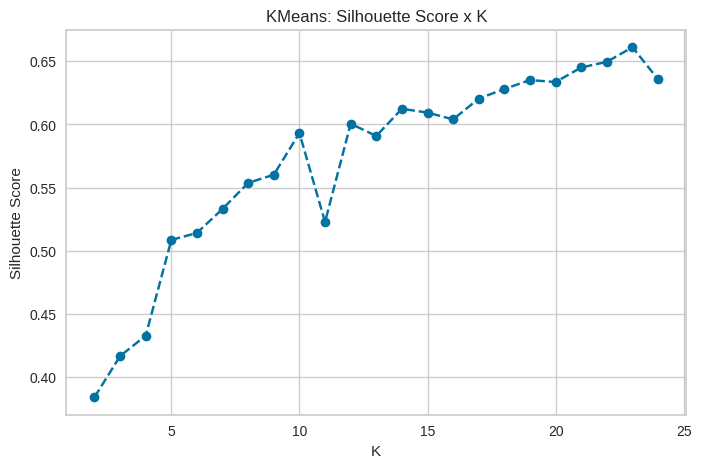

In [23]:
plt.figure( figsize=(8, 5) )
plt.plot( cluster, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score');
plt.title('KMeans: Silhouette Score x K');

### 2.2.2 - Gaussiann Mixture Model

AIC - Data Adjustments
BIC - Parameters Adjustments

In [24]:
gmm_list = [] 
for k in cluster:
    # Model Definition
    gmm_model = mx.GaussianMixture( n_components=k )
    
    # Model Training
    gmm_model.fit( X )

    # Model Predict
    labels = gmm_model.predict( X )

    # Model Performance
    gmm_sil = mt.silhouette_score( X, labels, metric='euclidean')
    gmm_list.append( gmm_sil )

Text(0.5, 1.0, 'GMM: Silhouette Score x K')

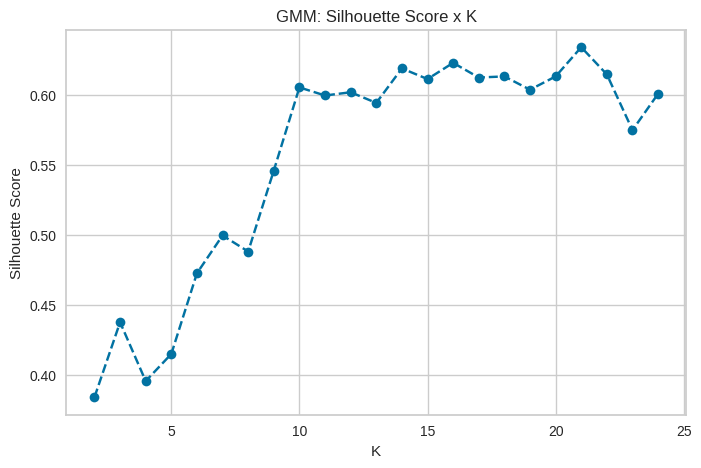

In [25]:
plt.figure( figsize=(8, 5) )
plt.plot( cluster, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score');
plt.title('GMM: Silhouette Score x K')

### 2.2.3 - Hierarchical Clustering

In [26]:
# Model Definition and Training
hc_model = hc.linkage( X, 'ward')

[]

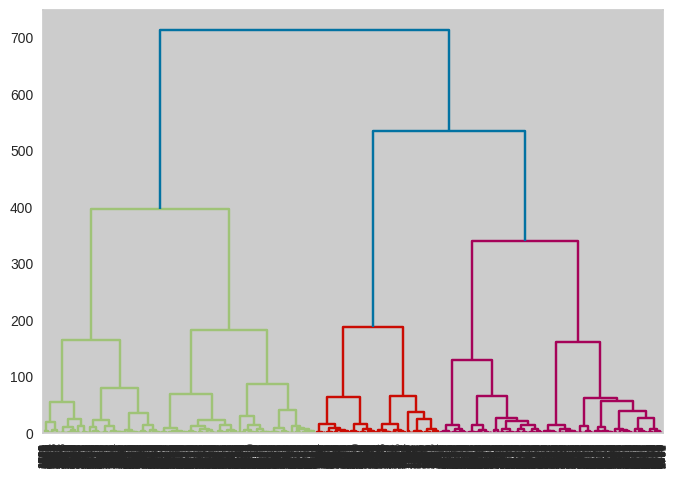

In [27]:
hc.dendrogram(
              hc_model,
              leaf_rotation=90,
              leaf_font_size=8
)

plt.plot()

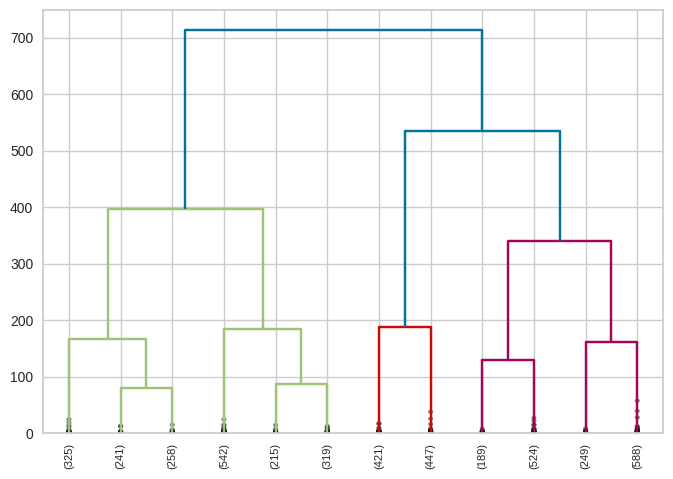

In [28]:
hc.dendrogram(
            hc_model,
            truncate_mode='lastp',
            p=12,
            leaf_rotation=90,
            leaf_font_size=8,
            show_contracted=True
)
plt.show()

### 2.2.4 - Hierarchical Cluster Silhouette

In [29]:
hc_list = []
for k in cluster:
    # Model Definition and Training
    hc_model = hc.linkage( X, 'ward' )

    # Model Predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = mt.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

Text(0.5, 1.0, 'HC: Silhouette Score x K')

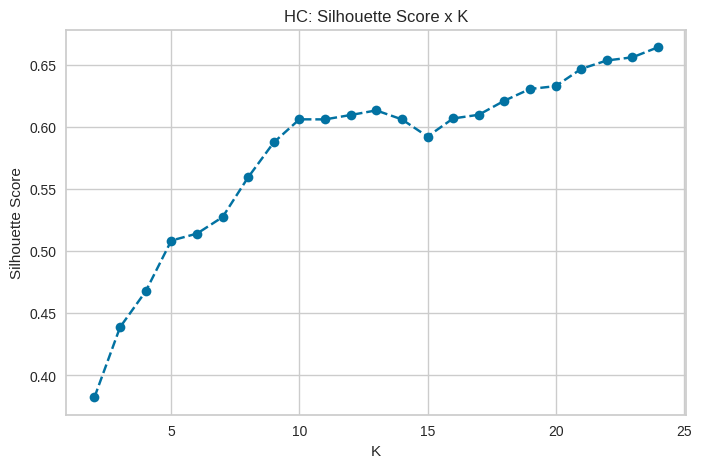

In [30]:
plt.figure( figsize=(8, 5) )
plt.plot( cluster, hc_list, linestyle='--', marker='o', color='b')
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score');
plt.title('HC: Silhouette Score x K')

### 2.2.5 - Silhouette Analysis

 For K = 2. Silhouette Score: 0.38244256377220154
 For K = 3. Silhouette Score: 0.4388154447078705
 For K = 4. Silhouette Score: 0.4676642417907715
 For K = 5. Silhouette Score: 0.5085151791572571
 For K = 6. Silhouette Score: 0.5140898823738098
 For K = 7. Silhouette Score: 0.5273858308792114
 For K = 8. Silhouette Score: 0.5594558715820312
 For K = 9. Silhouette Score: 0.5875194072723389
 For K = 10. Silhouette Score: 0.6060840487480164
 For K = 11. Silhouette Score: 0.6060163974761963
 For K = 12. Silhouette Score: 0.6095559000968933
 For K = 13. Silhouette Score: 0.613248348236084
 For K = 14. Silhouette Score: 0.6060277223587036
 For K = 15. Silhouette Score: 0.5922232866287231
 For K = 16. Silhouette Score: 0.6067838072776794
 For K = 17. Silhouette Score: 0.6097307801246643
 For K = 18. Silhouette Score: 0.6210564970970154
 For K = 19. Silhouette Score: 0.6304923892021179
 For K = 20. Silhouette Score: 0.6327811479568481
 For K = 21. Silhouette Score: 0.6466699242591858
 For K =

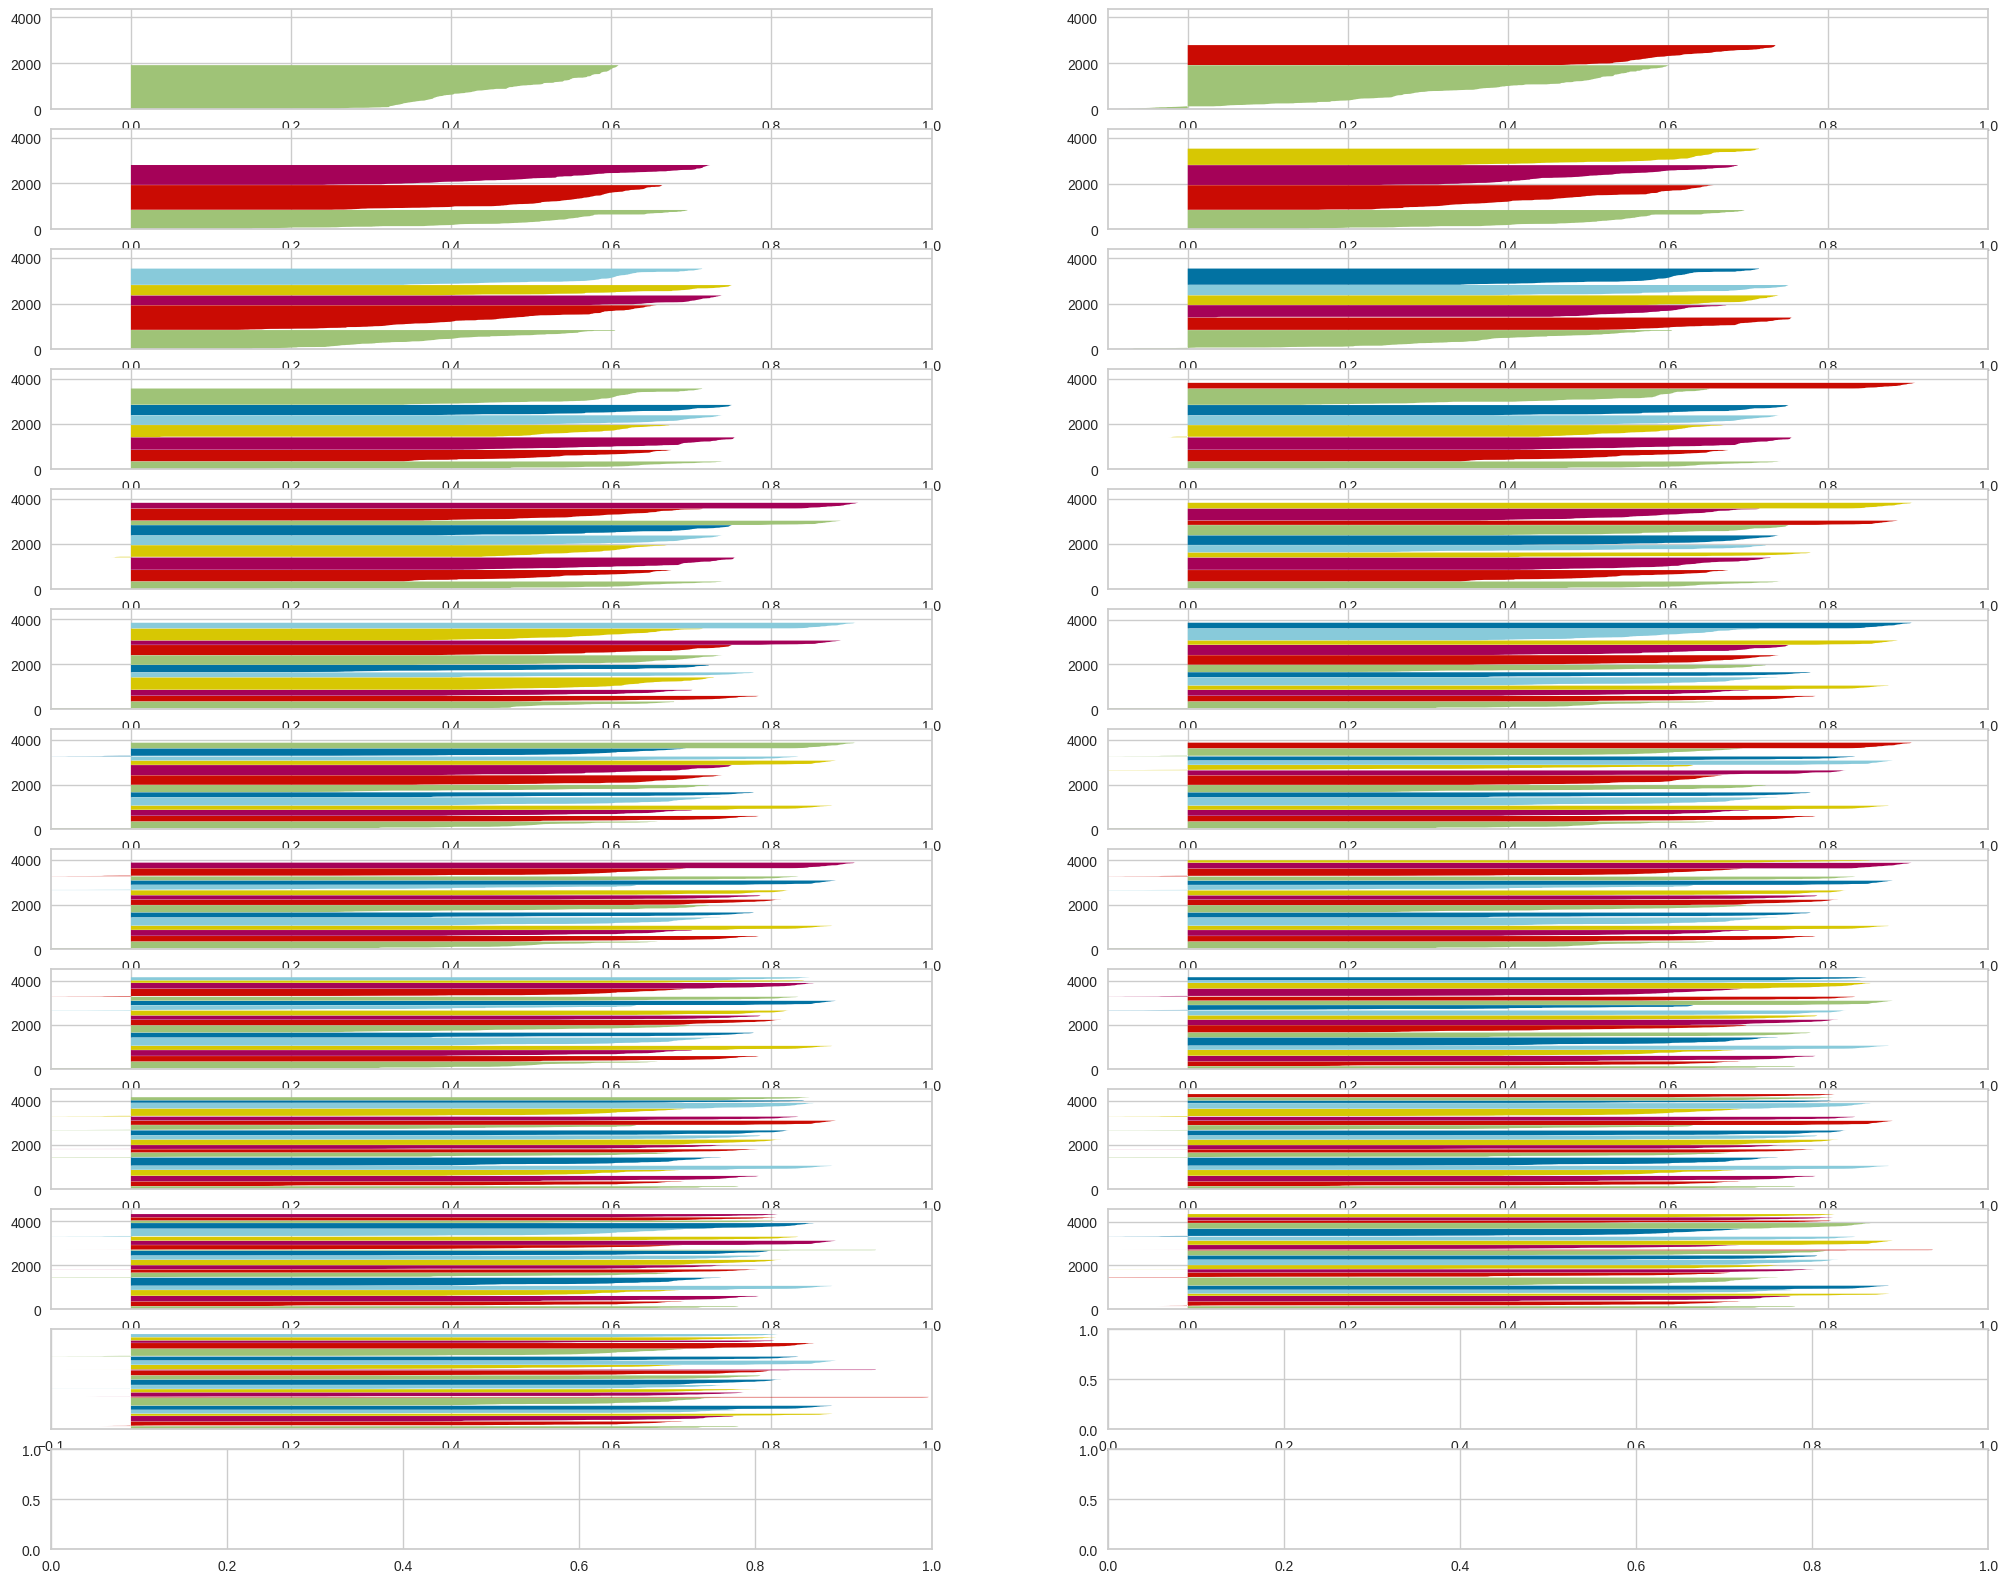

In [31]:
fig, ax = plt.subplots( 13, 2 )
fig.set_size_inches( 25, 20 )

for k in cluster:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [-0.1, 1] )
    ax[q-1, mod].set_ylim( [0, len( X ) + ( k+1 )*10] )
    
    # Model Definition and Training
    hc_model = hc.linkage( X, 'ward')

    # Model Predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust')
    
    # Performance
    ss = mt.silhouette_score( X, labels, metric='euclidean')
    print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

    
    samples_silhouette_values = mt.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):
        # Select Clusters
        ith_samples = samples_silhouette_values[ labels == i ]

        # Size Clusters
        size_cluster_i = ith_samples.shape[0]
        
        # Sort values
        ith_samples.sort()    

        # Limits
        y_upper = y_lower + size_cluster_i

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples )
        
        y_lower = y_upper + 10 
     
        cmap = cm.get_cmap( 'Spectral')
        color = cmap( i/k )
    
    
    
    
ax[q-1, mod].set_yticks([])
ax[q-1, mod].set_xticks([-0.1, 0.2, 0.4, 0.6, 0.8, 1])

### 2.2.6 - Results

In [32]:
df_results = pd.DataFrame(
                          {'KMeans': kmeans_list,
                           'GMM': gmm_list,
                           'HC':hc_list}
).T

df_results.columns = cluster

In [33]:
df_results.style.highlight_max( color='lightgreen', axis=1 ) #identifying the highest value for each ml model

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.383983,0.416536,0.432705,0.508515,0.514090,0.533109,0.553738,0.560171,0.593179,0.522720,0.600540,0.590852,0.612377,0.609380,0.603975,0.620458,0.628066,0.635123,0.633552,0.645087,0.649550,0.661130,0.635632
GMM,0.384081,0.437710,0.395628,0.415011,0.472739,0.499756,0.488266,0.546174,0.605624,0.599842,0.602161,0.594544,0.619204,0.611605,0.623193,0.612709,0.613479,0.603981,0.613466,0.634364,0.614914,0.575086,0.601078
HC,0.382443,0.438815,0.467664,0.508515,0.514090,0.527386,0.559456,0.587519,0.606084,0.606016,0.609556,0.613248,0.606028,0.592223,0.606784,0.609731,0.621056,0.630492,0.632781,0.646670,0.653436,0.655985,0.664096


## 3 - MACHINE LEARNING AFTER TUNING

### 3.1 - K-MEANS

In [34]:
# Model Definition
k = 22
kmeans = cc.KMeans( init='random', n_clusters=k, n_init=300, random_state=42 )

# Model Trainin
kmeans.fit( X )

# Model Prediction
labels = kmeans.labels_

### 3.2 - GMM

In [ ]:
# k = 22
# # Model Definition
# gmm_model = mx.GaussianMixture( n_components=k, n_init=300, random_state=42  )
    
# # Model Training
# gmm_model.fit( X )

# # Model Predict
# labels = gmm_model.predict( X )

### 3.3 - HC

In [ ]:
# k = 24
# # Model Definition and Training
# hc_model = hc.linkage( X, 'ward' )

# # Model Predict
# labels = hc.fcluster( hc_model, k, criterion='maxclust' )

## 4 - CLUSTER ANALYSIS

In [35]:
df9 = X.copy()
df9['cluster'] = labels

## 4.1 - VIZUALIZATION INSPECTION

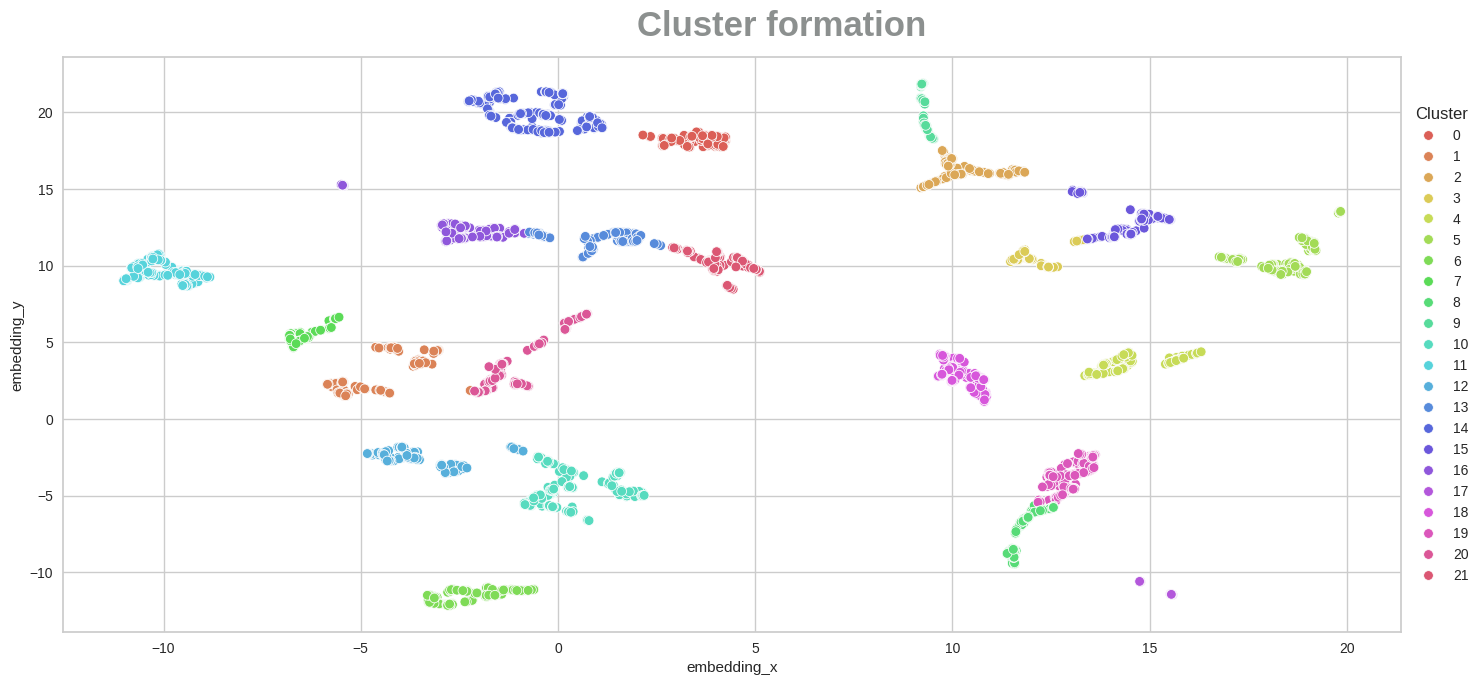

In [36]:
# Definindo a figura e os eixos para o gráfico de dispersão
fig, ax = plt.subplots(figsize=(15, 7))

# Gráfico de dispersão com legenda de cores para clusters
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette=sns.color_palette("hls", 22), ax=ax)

# Título
plt.text(x=2, y=25, s='Cluster formation', fontsize=25, color='#8C908F', weight='bold')

# Movendo a legenda para fora do gráfico
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Cluster")  # Ajuste de posição da legenda

fig.tight_layout()
plt.show()

## 4.4 - CLUSTER PROFILE

In [50]:
df4 = df1.copy()
df4['cluster'] = labels
df4.head()

,customer_id,gross_revenue,recency_days,qty_invoices,qty_prod_purchased,range_of_products,avg_ticket,frequency,qty_returns,avg_qty_products_purchased,week_day,month,cluster
0,17850,4046.51,372,34,1191,204,19.835833,17.000000,37.0,35.029412,2.0,11.0,4
1,13047,2392.96,31,10,1159,130,18.407385,0.029155,36.0,115.900000,1.0,11.0,5
2,12583,6507.44,2,15,4854,225,28.921956,0.040323,51.0,323.600000,1.0,11.0,8
3,13748,948.25,95,5,439,28,33.866071,0.017921,0.0,87.800000,2.0,4.0,9
4,15291,4396.00,25,15,1949,96,45.791667,0.042980,29.0,129.933333,6.0,3.0,18


In [38]:
df4[['gross_revenue', 'cluster']].groupby('cluster').sum().reset_index().sort_values(by='gross_revenue', ascending=False)

,cluster,gross_revenue
17,17,1985016.74
8,8,1588250.57
19,19,905293.12
18,18,636436.22
5,5,434622.31
4,4,386219.59
15,15,265543.40
14,14,244489.22
2,2,194348.42
0,0,167096.88


In [47]:
# Number of Customer
df_cluster = df4[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross Revenue
df_avg_gross_revenue = df4[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg Recency Days
df_avg_recency_days = df4[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg Qty Products
df_qty_product = df4[['qty_prod_purchased', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qty_product, how='inner', on='cluster')

# Avg Frequency
df_freq = df4[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_freq, how='inner', on='cluster')

# # Avg Returns
# df_ret = df4[['qty_returns', 'cluster']].groupby('cluster').mean().reset_index()
# df_cluster = pd.merge( df_cluster, df_ret, how='inner', on='cluster')

df_cluster.sort_values(by='gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qty_prod_purchased,frequency,qty_returns
17,17,31,0.717925,64032.798065,11.193548,38463.193548,0.141750,1318.935484
8,8,195,4.515980,8144.874718,25.620513,5247.000000,0.106730,142.374359
19,19,221,5.118110,4096.348959,27.339367,2469.610860,0.064062,37.547511
18,18,238,5.511811,2674.101765,38.903361,1700.605042,0.051995,26.483193
4,4,183,4.238073,2110.489563,40.639344,1305.814208,0.176945,32.852459
5,5,241,5.581288,1803.412075,39.663900,965.282158,0.037096,14.609959
15,15,181,4.191755,1467.090608,50.535912,910.497238,0.110650,16.016575
3,3,110,2.547476,1140.193818,67.845455,801.209091,0.228826,7.245455
2,2,174,4.029643,1116.944943,60.172414,619.252874,0.108973,7.321839
9,9,118,2.732747,977.126017,53.703390,425.652542,0.029941,20.855932


In [51]:
seg_map = {
    17: 'Insiders',
    8: 'Champions',
    19: 'Loyalists',
    18: 'Big Spenders',
    4: 'Potential Loyalists',
    5: 'New Customers',
    15: 'Promising',
    3: 'Active Customers',
    2: 'High Value Newcomers',
    9: 'Rising Stars',
    0: 'Occasional Buyers',
    14: 'Need Attention',
    13: 'About to Sleep',
    11: 'Hibernating',
    21: 'At Risk',
    16: 'Lost Champions',
    20: 'Price Sensitive',
    7: 'One-Timers',
    1: 'Bargain Hunters',
    12: 'Low Value Customers',
    10: 'Churned',
    6: 'Ghosts'
}

df4['cluster'] = df4['cluster'].replace(seg_map)

In [74]:
df4.to_csv('../data/processed/ml_cluster.csv', index=False)